# Imports and Setup

In [3]:
import os
import pandas as pd
import geopandas as gpd
import logging

import sys
sys.path.insert(0, "../utils/")
import model_utils
import config_utils
import embed_utils
import data_utils
from foundation import Foundation

import torch
import torch.nn as nn
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
%load_ext autoreload
%autoreload 2

# DINOv2 Embeddings

## Data Configurations

In [4]:
iso_code = "SEN"
cwd = os.path.dirname(os.getcwd())
config_file = os.path.join(cwd, f"configs/model_configs/dinov2_vits14-LR.yaml")
config = config_utils.load_config(config_file)
config["iso_codes"] = [iso_code]
print(config["ghsl_smod_file"])

data = model_utils.load_data(config, attributes=["rurban", "iso"], verbose=False)
data.head(3)

GHS_SMOD_E2030_GLOBE_R2023A_54009_1000_V1_0.tif


,UID,source,iso,country,region,subregion,name,giga_id_school,clean,class,ghsl_smod,rurban,dataset,geometry
0,OSM-SEN-SCHOOL-00000000,OSM,SEN,Senegal,Africa,Sub-Saharan Africa,Ecole Nationale de Police,None,0,school,1,urban,test,POINT (-1713262.938 1808584.891)
1,OSM-SEN-SCHOOL-00000001,OSM,SEN,Senegal,Africa,Sub-Saharan Africa,CIFOP,None,0,school,1,urban,train,POINT (-1657193.467 1866870.025)
2,OSM-SEN-SCHOOL-00000002,OSM,SEN,Senegal,Africa,Sub-Saharan Africa,Sainte Bernadette,None,0,school,1,urban,train,POINT (-1714666.161 1811188.139)


## Load Model

In [5]:
model = torch.hub.load("facebookresearch/dinov2", config["embed_model"])
model.name = config["embed_model"]
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
model.to(device)

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to C:\Users\andri/.cache\torch\hub\main.zip
C:\Users\andri/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\andri/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\andri/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
INFO:dinov2:using MLP layer as FFN
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to C:\Users\andri/.cache\torch\hub\checkpoints\dinov2_vits14_pretrain.pth
100%|██████████| 84.2M/84.2M [00:02<00:00, 35.3MB/s]


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

## Urban Schools

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex:sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex:sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.decomposition.PCA.fit: fallback to original Scikit-learn
INFO:sklearnex:sklearn.decomposition.PCA.fit: fallback to original Scikit-learn
INFO:sklearnex: sklearn.decomposition.PCA.transform: running accelerated version on CPU
INFO:sklearnex:sklearn.decomposition.PCA.transform: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex:sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


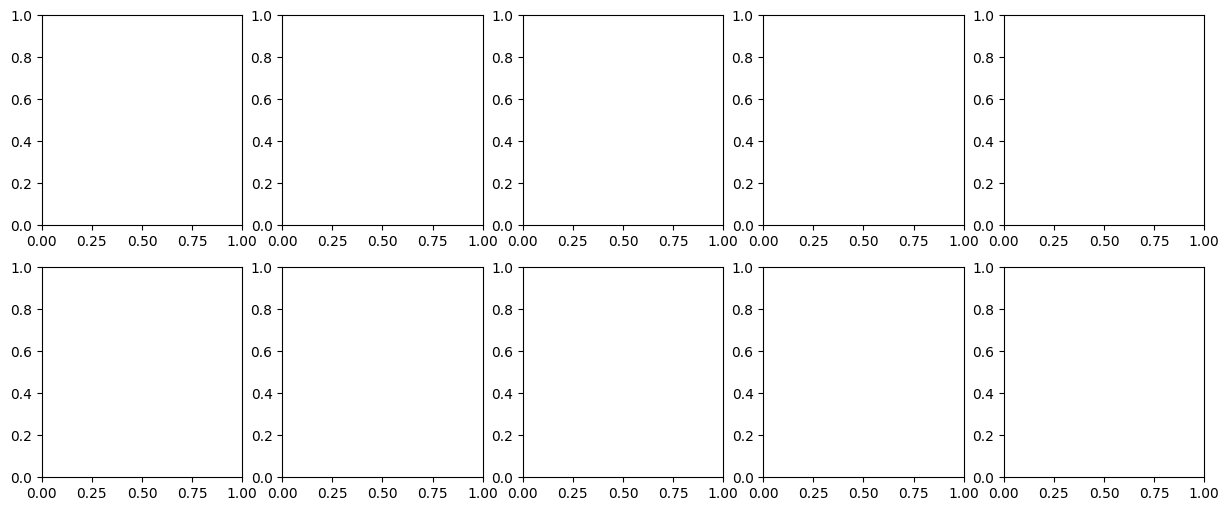

In [8]:
subdata = data[(data.rurban=="urban") & (data["class"] == "school")]
embed_utils.visualize_embeddings(config, subdata, model, batch_size=5)

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex:sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex:sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.decomposition.PCA.fit: fallback to original Scikit-learn
INFO:sklearnex:sklearn.decomposition.PCA.fit: fallback to original Scikit-learn
INFO:sklearnex: sklearn.decomposition.PCA.transform: running accelerated version on CPU
INFO:sklearnex:sklearn.decomposition.PCA.transform: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex:sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


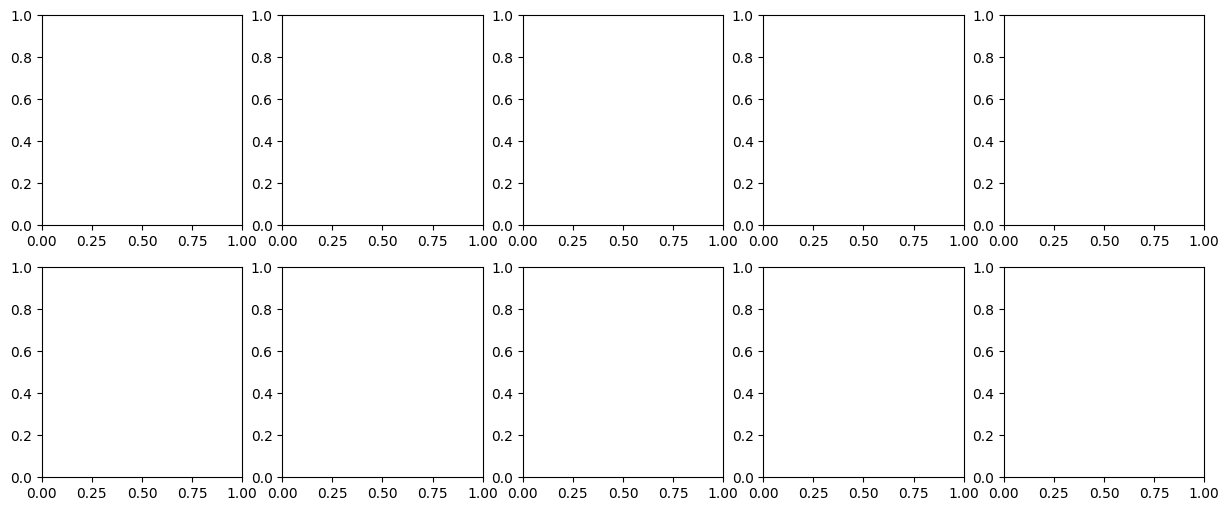

In [9]:
subdata = data[(data.rurban=="urban") & (data["class"] == "non_school")]
embed_utils.visualize_embeddings(config, subdata, model, batch_size=5)

## Rural Schools

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex:sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex:sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.decomposition.PCA.fit: fallback to original Scikit-learn
INFO:sklearnex:sklearn.decomposition.PCA.fit: fallback to original Scikit-learn
INFO:sklearnex: sklearn.decomposition.PCA.transform: running accelerated version on CPU
INFO:sklearnex:sklearn.decomposition.PCA.transform: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex:sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


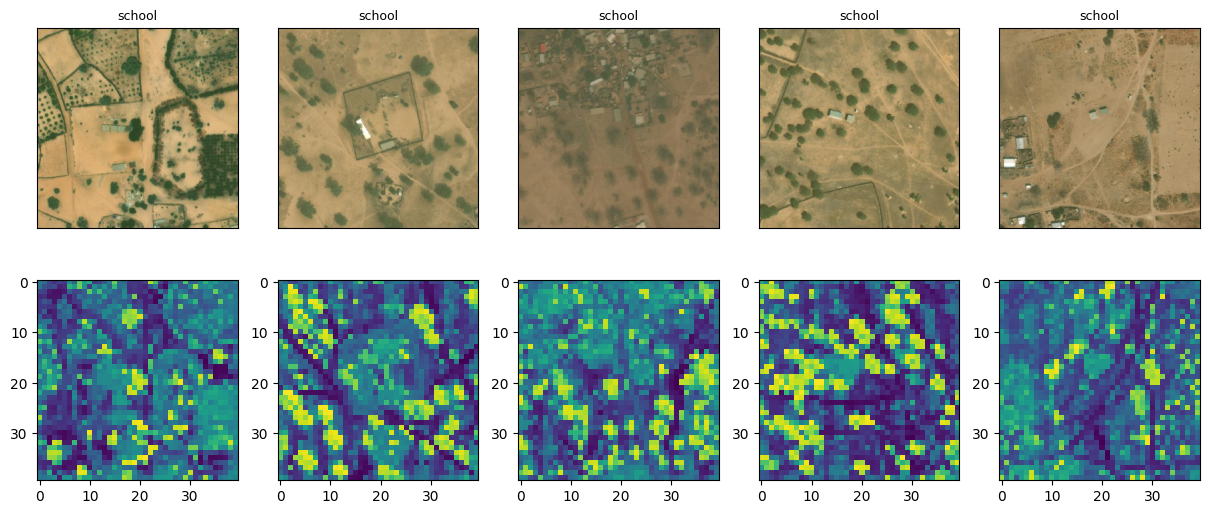

In [19]:
subdata = data[(data.rurban=="rural") & (data["class"] == "school")]
embed_utils.visualize_embeddings(config, subdata, model, batch_size=5)

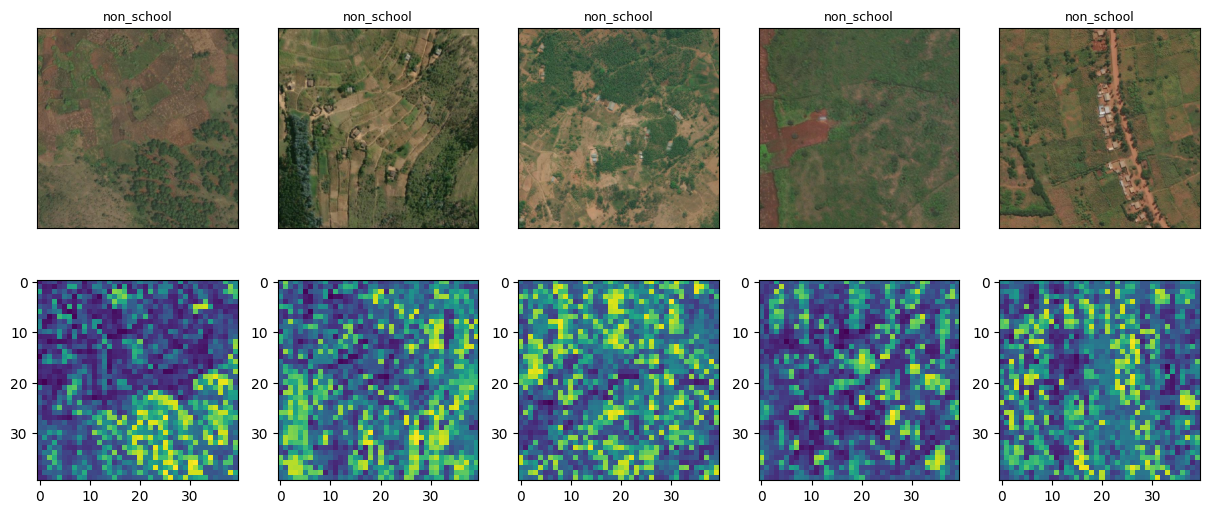

In [24]:
subdata = data[(data.rurban=="rural") & (data["class"] == "non_school")]
embed_utils.visualize_embeddings(config, subdata, model, batch_size=5)

## Compute Embeddings

In [16]:
out_dir = os.path.join(config["vectors_dir"], "embeddings")
embeddings = embed_utils.get_image_embeddings(
    config, data, model, out_dir, in_dir=None, columns=["iso", "rurban", "dataset", "class"]
)
embeddings.head(3)

INFO:root:Reading file /home/itingzon.unicef/giga/data/vectors/embeddings/MNG_dinov2_vits14_embeds.csv


,UID,0,1,2,3,4,5,6,7,8,...,378,379,380,381,382,383,iso,rurban,dataset,class
0,OVERTURE-MNG-SCHOOL-00000005,-2.888033,-0.108523,5.691371,-2.143276,0.669561,-2.958966,-2.102606,0.754148,-0.106829,...,1.265511,-3.531531,-0.315876,1.205464,-2.272689,3.702338,MNG,urban,train,school
1,OVERTURE-MNG-SCHOOL-00000006,-2.589591,-0.156911,5.571325,-4.166053,0.541174,-0.911260,-2.040312,-0.669896,-1.048705,...,1.132965,-1.922010,1.084568,2.454362,-5.554929,3.728537,MNG,urban,train,school
2,OVERTURE-MNG-SCHOOL-00000018,-2.531917,0.847107,3.817045,-2.197662,2.105122,-0.644953,-2.360759,0.050235,1.632953,...,2.703199,-2.559021,-0.785523,0.349606,-3.324399,4.424771,MNG,urban,train,school


# ESA Foundation Model Embeddings

## Model Configs

In [2]:
iso_code = "BWA"
cwd = os.path.dirname(os.getcwd())
config_file = os.path.join(cwd, f"configs/model_configs/esa_foundation-LR.yaml")
config = config_utils.load_config(config_file)
config["iso_codes"] = [iso_code]

data = model_utils.load_data(config, attributes=["rurban", "iso"], verbose=False)
data.head(3)

,UID,source,iso,country,region,subregion,name,giga_id_school,clean,validated,class,ghsl_smod,rurban,dataset,geometry
0,OVERTURE-BWA-SCHOOL-00000000,OVERTURE,BWA,Botswana,Africa,Sub-Saharan Africa,Serule Primary School,None,0,0.0,school,13,rural,train,POINT (2612095.427 -2684825.662)
1,OVERTURE-BWA-SCHOOL-00000001,OVERTURE,BWA,Botswana,Africa,Sub-Saharan Africa,Kang Primary School,None,0,0.0,school,23,urban,train,POINT (2163196.151 -2894439.869)
2,OVERTURE-BWA-SCHOOL-00000003,OVERTURE,BWA,Botswana,Africa,Sub-Saharan Africa,Gantsi Senior School Ground,None,0,0.0,school,23,urban,train,POINT (2072772.072 -2658792.498)


## Load Model

In [3]:
model_file = os.path.join(cwd, f"models/foundation_local_v03_e011.pt")
model = Foundation(
    input_dim=config["input_dim"],
    depths=config["depths"], 
    dims=config["dims"],
    img_size=config["image_size"],
    latent_dim=config["latent_dim"],
    dropout=config["dropout"],
    activation=nn.ReLU6(),
)
model.name = config["embed_model"]
model.load_state_dict(torch.load(model_file, map_location=device), strict=False)
model.eval();

## Compute Embeddings

In [4]:
image_files = data_utils.get_image_filepaths(config, data)
out_dir = os.path.join(config["vectors_dir"], "embeddings")
embeddings = embed_utils.get_image_embeddings(
    config, data, model, out_dir, columns=["iso", "rurban", "dataset", "class"]
)
embeddings.head(3)

100%|████████████████████| 2606/2606 [8:04:05<00:00, 11.15s/it]                                                         
INFO:root:Saved to /home/itingzon.unicef/giga/data/vectors/embeddings/BWA_esa_foundation_embeds.csv


,0,1,2,3,4,5,6,7,8,9,...,1018,1019,1020,1021,1022,1023,iso,rurban,dataset,class
UID,,,,,,,,,,,,,,,,,,,,,
OVERTURE-BWA-SCHOOL-00000000,1.292681,-0.423336,0.580245,-1.329876,-1.086299,-0.238224,-0.605698,0.669051,-0.156950,0.031464,...,-1.082415,-0.739226,0.737304,-0.580990,-0.540339,-1.312907,BWA,rural,train,school
OVERTURE-BWA-SCHOOL-00000001,0.761518,-0.303446,0.549824,-1.317577,-1.619856,0.438902,-0.861322,0.867736,0.428994,-0.188972,...,-0.994569,-0.436137,0.894621,-0.735322,-0.212001,-0.993920,BWA,urban,train,school
OVERTURE-BWA-SCHOOL-00000003,1.003423,-0.233891,0.364701,-1.095844,-1.526610,0.093927,-0.672186,0.570617,0.162825,0.060725,...,-0.743859,-0.411639,0.754309,-0.616263,-0.295198,-1.178626,BWA,urban,train,school
